In [ ]:
%pip install python-Levenshtein
%pip install distance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16256 sha256=1313a47339988019b2c724c4035448c10957ea00d33b7c8d66cf7af127ca76d3
  Stored in directory: /root/.cache/pip/wheels/e8/bb/de/f71bf63559ea9a921059a5405806f7ff6ed612a9231c4a9309
Successfully built distance


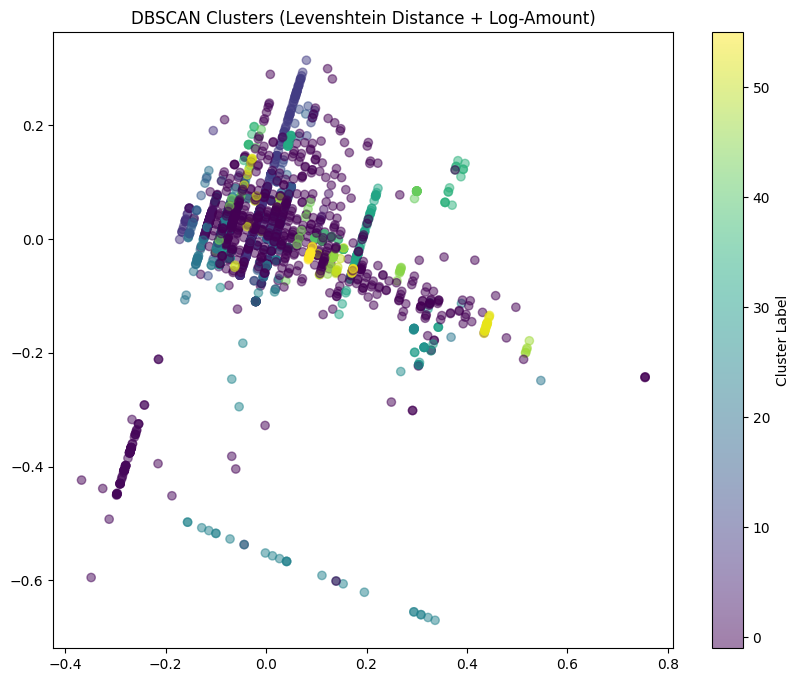

Cluster 0:
Merchant: Paypal, Amount: 5.0, Notes: nan
Merchant: Paypal, Amount: 6.0, Notes: nan
Merchant: Paypal, Amount: 1.04, Notes: nan
Merchant: Paypal, Amount: 182.0, Notes: nan
Merchant: Paypal, Amount: 182.0, Notes: nan
Merchant: Paypal, Amount: 1.75, Notes: nan
Merchant: Paypal, Amount: 0.96, Notes: nan
Merchant: Paypal, Amount: 5.0, Notes: nan
Merchant: Paypal, Amount: 6.0, Notes: nan
Merchant: Paypal, Amount: 4.95, Notes: nan
Noise Points: 637
Cluster 1:
Merchant: GoFood, Amount: 39800.0, Notes: nan
Merchant: GoFood, Amount: 39800.0, Notes: nan
Merchant: GoFood, Amount: 51000.0, Notes: nan
Merchant: GoFood, Amount: 23500.0, Notes: nan
Merchant: GoFood, Amount: 22800.0, Notes: nan
Merchant: GoFood, Amount: 35000.0, Notes: nan
Merchant: GoFood, Amount: 107000.0, Notes: nan
Merchant: GoFood, Amount: 250000.0, Notes: nan
Merchant: GoFood, Amount: 55400.0, Notes: nan
Merchant: GoFood, Amount: 23800.0, Notes: nan
Cluster 2:
Merchant: FLIPTECH LENTERA INS, Amount: 65217.0, Notes: -
M

In [2]:
import pandas as pd
import numpy as np
import Levenshtein  # Menggunakan python-Levenshtein untuk menghitung Levenshtein distance
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from collections import defaultdict

# 1. Load data dan preprocessing
csv_file_path = "merge-csv-training.csv"
df = pd.read_csv(csv_file_path, sep=";", on_bad_lines="skip")

# Pastikan kolom yang dibutuhkan ada
if "Merchant Name" not in df.columns or "Notes" not in df.columns or "Amount" not in df.columns:
    raise ValueError("CSV file harus mengandung kolom 'Merchant Name', 'Notes', dan 'Amount'")

# Pastikan Merchant Name dan Notes adalah string, dan isi NaN dengan string kosong
df["Merchant Name"] = df["Merchant Name"].astype(str).fillna("")
df["Notes"] = df["Notes"].astype(str).fillna("")

# 2. Log Transformation of Amount
df["Log_Amount"] = np.log10(df["Amount"].replace(0, np.nan)).fillna(0)

# 3. Menghitung Levenshtein Distance antar Merchant Name dan Notes
def compute_levenshtein_distance(row):
    # Pastikan bahwa 'Merchant Name' dan 'Notes' adalah string yang valid
    return Levenshtein.distance(row['Merchant Name'], row['Notes'])

# Tambahkan kolom Levenshtein Distance
df["Levenshtein_Dist"] = df.apply(compute_levenshtein_distance, axis=1)

# 4. Normalisasi Levenshtein Distance dan Log-Amount
scaler = MinMaxScaler()
log_amount_normalized = scaler.fit_transform(df["Log_Amount"].values.reshape(-1, 1))
levenshtein_normalized = scaler.fit_transform(df["Levenshtein_Dist"].values.reshape(-1, 1))

# 5. Gabungkan fitur untuk clustering
# Gabungkan Log-Amount yang sudah dinormalisasi dan Levenshtein Distance yang sudah dinormalisasi
features = np.hstack([log_amount_normalized, levenshtein_normalized])

# 6. Buat matriks jarak menggunakan Levenshtein Distance
# Ini adalah matriks jarak precomputed untuk digunakan dengan DBSCAN
levenshtein_matrix = np.array([[Levenshtein.distance(x1, x2) for x1 in df['Merchant Name']] for x2 in df['Merchant Name']])

# 7. Apply DBSCAN Clustering dengan jarak kustom
# Gunakan DBSCAN dengan `metric="precomputed"` karena kita menggunakan matriks jarak
dbscan = DBSCAN(metric="precomputed", eps=0.5, min_samples=5)
dbscan.fit(levenshtein_matrix)  # Gunakan matriks Levenshtein

# 8. Visualisasikan cluster
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

plt.figure(figsize=(10, 8))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=dbscan.labels_, cmap='viridis', alpha=0.5)
plt.title("DBSCAN Clusters (Levenshtein Distance + Log-Amount)")
plt.colorbar(label='Cluster Label')
plt.show()

# 9. Analisis Hasil Cluster
clusters = defaultdict(list)
for i, label in enumerate(dbscan.labels_):
    clusters[label].append(df.iloc[i])

# Menampilkan cluster
for cluster_id, cluster_data in clusters.items():
    if cluster_id != -1:  # -1 menunjukkan noise
        print(f"Cluster {cluster_id}:")
        for transaction in cluster_data[:10]:  # Tampilkan 10 transaksi pertama per cluster
            print(f"Merchant: {transaction['Merchant Name']}, Amount: {transaction['Amount']}, Notes: {transaction['Notes']}")
    else:
        print(f"Noise Points: {len(cluster_data)}")

In [ ]:
import pandas as pd

csv_file_path = "nathan-email-extract.csv"

# Use the 'error_bad_lines=False' argument to skip problematic lines
df = pd.read_csv(csv_file_path, sep=";", on_bad_lines='skip')
# or
# df = pd.read_csv(csv_file_path, on_bad_lines=lambda bad_line: bad_line[:3])

print(df.columns)  # Check the exact column names

Index(['Datetime', 'Merchant Name', 'Sub Category', 'Category', 'Amount',
       'Currency', 'Transaction Type', 'Payment Method', 'Transaction ID',
       'Notes'],
      dtype='object')
